## Luminol basics

The Luminol anomaly detection Python library is based on the approach from *Assumption-Free Anomaly Detection in Time Series* by Li Wei et al. (2005). Other approaches to anomaly detection are often suitable only for a particular domain, while this approach performs well for a wide range of domains.

This method uses timeseries bitmaps to quantify the frequency of certain value changes in the timeseries.

Detailed description of this method and its application in this project is the purpose of this notebook.

### Bitmap sequence representation

The idea was originaly used for visual representation of animals DNA sequencies. The resulting bitmaps can be easily compared visually and statistically.

The DNA alphabet consists of four letters: C, T, A, G. The frequency of DNA substrings of length *L* can be counted, mapped into a *2L* by *2L* matrix and color coded into the resulting bitmap.

![matrices](img/matrices.png)
**Fig. 1** The quad-tree representation of a sequence over the alphabet {A,C,G,T} at different levels of resolution. *Source: Wei et al. (2004)*

![genomes](img/genomes.png)
**Fig. 2** The bitmap representation of the gene sequences of four animals.
*Source: Wei et al. (2005)*

### Timeseries bitmaps

Let's take a look at the method in practice. First we load the daily averages of air temperature for March 2019 at *Botanical garden* in Brno.

In [1]:
import pandas as pd
ts = pd.read_csv('data/data.csv', index_col='date', parse_dates=True)
ts = ts['2019-03-01':'2019-04-01']

In [2]:
ts

,t
date,
2019-03-01 00:00:00,7.100
2019-03-01 01:00:00,7.467
2019-03-01 02:00:00,8.267
2019-03-01 03:00:00,7.950
2019-03-01 04:00:00,7.817
...,...
2019-04-01 19:00:00,9.000
2019-04-01 20:00:00,8.317
2019-04-01 21:00:00,7.483


In [3]:
ts.plot(figsize=(12,7))

Now we need to classify the values into a limited number of categories. The original method uses *four*, the letters of the DNA alphabet, but we can chose any number we see fit. This parameter is called *precision*.

To determine the bounds of each category, we find maximum and minimum values in the timeseries and divide the difference by precision.

The resulting dictionary contains the lower bound for each category.

In [4]:
precision = 4

sections = {}
section_height = (ts.t.max() - ts.t.min()) / precision

for section in range(precision):
    sections[section] = ts.t.min() + section * section_height
    
import json
print(json.dumps(sections, indent=1))

{
 "0": -1.117,
 "1": 4.383000000000001,
 "2": 9.883000000000003,
 "3": 15.383000000000003
}


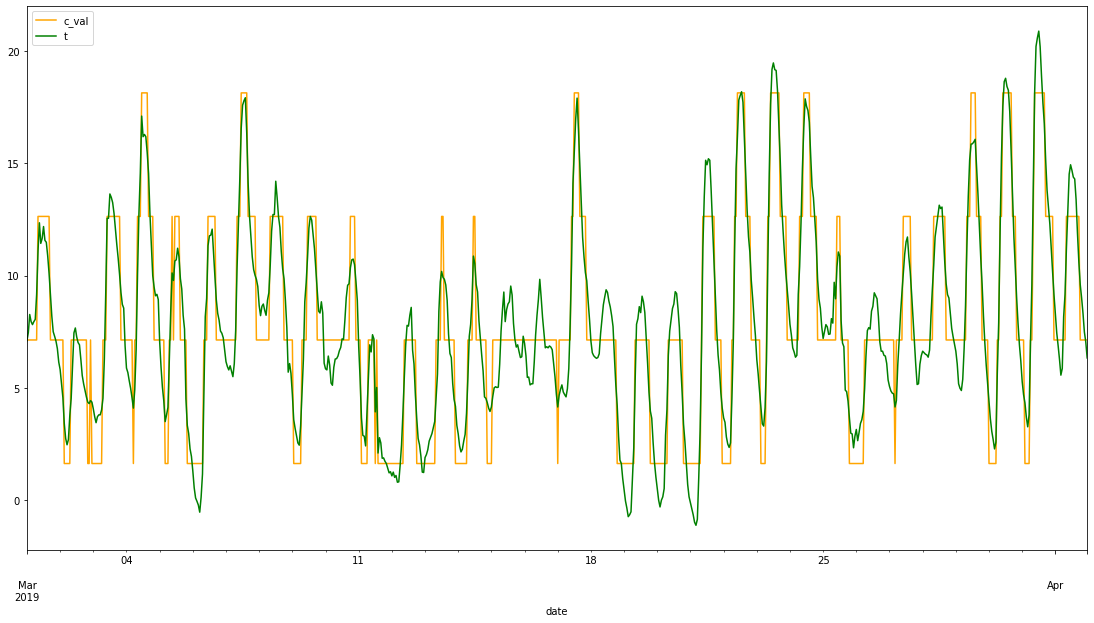

In [5]:
def generate_sax(row, sections):
    value = row['t']
    for section in sections.keys():
        section_lower_bound = sections[section]
        if value >= section_lower_bound:
            row['c'] = str(section)
            row['c_val'] = section_lower_bound + section_height / 2
    return row
            
ts = ts.apply(generate_sax, args=([sections]), axis=1)
ts[['c_val','t']].plot(figsize=(19,10), style=['orange','green'])

Air temperature values transformed into one string of category numbers:

In [6]:
sax_string = ''.join(ts['c'].to_list())
sax_string

'111111112222222221111111111000001111111111110010000000011122222222221111111110112223333322221111111100011212222111110000000000001112222221111111111111112223333322222211111111112222222222111111100000011112222222111111111111111111111111222211110000011111010000000000000000000111111111000000000000001111221111111100000000011112211111111000011111111111111111111111111111111111111111111111011111111122333322222111111111111111111111100000000000001111111111100000000000001111111111100000000000001222222222111110000000112233333322221111111000012233333332222211111111122233333222221111111111111122211111100000000000111111111111111111111101111122222211111111111111112222222221111111111111112223333222211111000000112233333332221111110000112333333332222221111111112222222222111111'

Two *windows* (timeseries subsets) are then compared for each datapoint:
* **lag window** - *N* previous values (not including the value itself)
* **lead window** - *N* following values (including the value itself)

Where the *N* parameter is called *window size*.

Frequencies of substrings of length *L* are counted in each window and the **anomaly value** of the data point is calculated as the sum of frequency differences for each substring squared.

Using:
* window size = 10
* substring length = 2

The first value we can analyze given these parameters is the 11th value (last would be *L - 10*).

* lagging window: '1111111122'
* leading window: '2222222111'

The frequencies of each substring is as follows:

| Substring | Lagging window | Leading window |
|-----------|----------------|---------------|
|00|0|0|
|01|0|0|
|02|0|0|
|03|0|0|
|10|0|0|
|11|**7**|**2**|
|12|**1**|0|
|13|0|0|
|20|0|0|
|21|0|**1**|
|22|**1**|**6**|
|23|0|0|
|30|0|0|
|31|0|0|
|32|0|0|
|33|0|0|

Given these values, the anomaly score would be:
\begin{align}
A_{11} & = (7-2)^2 + (1-0)^2 + (0-1)^2 + (1-6)^2 \\
A_{11} & = 25 + 1 + 1 + 25 \\
A_{11} & = 52
\end{align}

The window size parameter should be representative of the measured phenomena. For hourly teperature measurements, we can use window size of 24 to cover an entire day. Multiples of this value can also be used to detect longer term changes.

Following is the list of anomalies calculated using this method.

In [7]:
window_size = 24

combinations = [f'{i}{j}' for j in range(precision) for i in range(precision)]

def count_substring(string, substring):
    return sum(string[i:].startswith(substring) for i in range(len(string)))

def get_anomalies(sax, l):
    anomalies = []
    for i in range(len(sax)):
        score = 0
        if i >= l and i + l <= len(sax):
            for substring in combinations:
                score += (count_substring(sax_string[i-l:i], substring) - count_substring(sax_string[i:i+l], substring)) ** 2
        anomalies.append(score)
    
    return anomalies
        
ts['anom'] = get_anomalies(sax_string, window_size)
ts['anom'].to_list()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 104,
 116,
 132,
 142,
 136,
 120,
 108,
 100,
 90,
 72,
 56,
 46,
 38,
 46,
 70,
 110,
 166,
 224,
 264,
 308,
 324,
 290,
 232,
 192,
 158,
 130,
 118,
 122,
 128,
 138,
 150,
 150,
 150,
 156,
 172,
 168,
 132,
 106,
 92,
 90,
 100,
 114,
 130,
 150,
 148,
 120,
 108,
 100,
 80,
 64,
 52,
 44,
 40,
 40,
 40,
 48,
 48,
 52,
 72,
 72,
 54,
 26,
 14,
 18,
 28,
 28,
 28,
 32,
 40,
 38,
 38,
 42,
 50,
 62,
 78,
 98,
 114,
 114,
 98,
 92,
 118,
 118,
 108,
 104,
 98,
 96,
 98,
 100,
 104,
 116,
 136,
 154,
 152,
 110,
 62,
 30,
 14,
 14,
 30,
 62,
 92,
 120,
 152,
 208,
 272,
 250,
 214,
 204,
 204,
 198,
 196,
 198,
 226,
 250,
 246,
 224,
 190,
 146,
 114,
 88,
 72,
 60,
 52,
 48,
 48,
 52,
 60,
 72,
 72,
 56,
 44,
 42,
 40,
 44,
 64,
 100,
 142,
 144,
 116,
 80,
 48,
 32,
 32,
 38,
 38,
 38,
 32,
 28,
 28,
 32,
 40,
 52,
 58,
 54,
 48,
 46,
 46,
 48,
 54,
 64,
 76,
 76,
 64,
 54,
 48,
 46,


Since the frequency counts are squared and not normalized in the original implementation of the method, the value of resulting anomaly scores depends largely on the window size – the higher the window size, the higher the anomaly score.

This could pose problems for interpretation of the anomaly score, since the same score values could signify anomalies of very different severities.

Multiple options for normalization are available, for example dividing the frequency count of every substring by the window size, which would yield anomaly scores in the interval $[0,2)$.

In this case, we will scale the anomaly scores to match the interval of the measured temperature values.

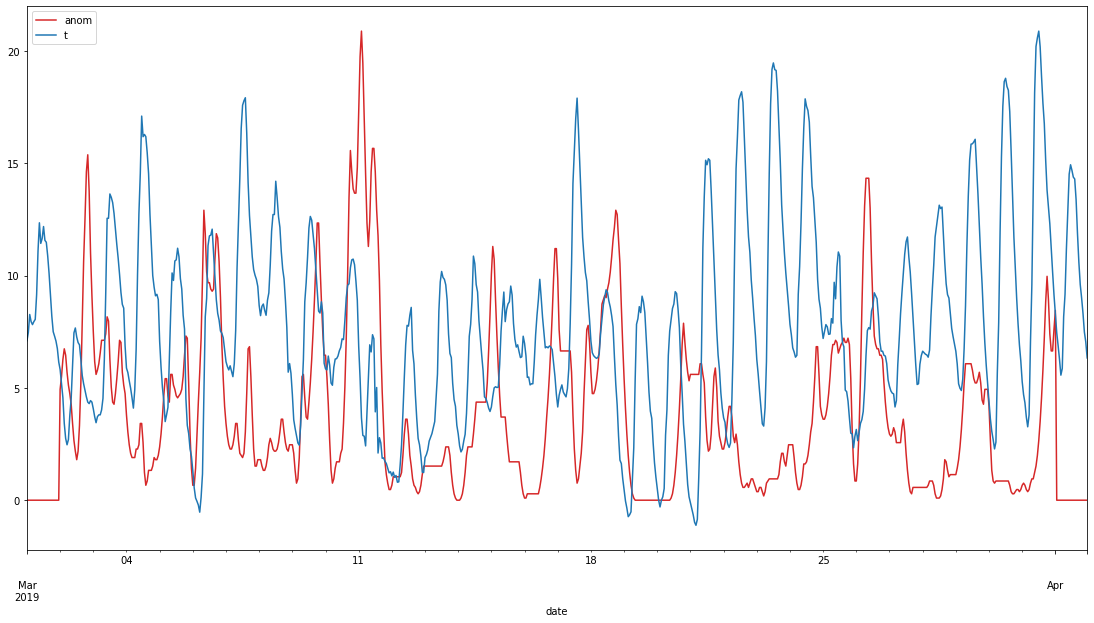

In [8]:
ts['anom'] /= max(ts['anom']) / max(ts['t'])

ts[['anom', 't']].plot(figsize=(19,10), style=['C3', 'C0'])

### Detector algorithms

Multiple variations of the original algoritm were implemented and tested. One of them was normalizing the calculated frequency values to make it possible to compare anomaly scores calculated using different window sizes.

Another issue was the missing anomaly scores for the first and last *N* values of the timeseries. These can be calculated using a decreasing *window size*.

### Timeseries baseline

Another option to the former approach is to replace the lag window with a *baseline timeseries* – series of data that represents behaviour of the phenomena considered as normal.

To better represent each value, the lead window is centred around it in this case. E.g. for *window size* 10 and the 5th value, the lead window would consist of values 1 to 10, inclusive.

This also helps to reduce some uncertainty at the timeseries borders, since the anomaly score of every value is calculated using $N/2$ adjacent values.

One final variant was to use the baseline and the *lag* window instead of a centred one. This makes it possible to calculate anomaly score even for the latest values, but is practically the same as shifting the anomaly scores from values $i$ to $i + N/2$ and is therefore considered less representative.